In [2]:
%%file helper.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['eigen']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>
#include <Eigen/Dense>
#include <random>

namespace py = pybind11;

std::default_random_engine generator;

        
// apply gradU function in C++

Eigen::MatrixXd gradU(Eigen::MatrixXd theta) {
    
    Eigen::MatrixXd noise = Eigen::MatrixXd::Zero(theta.rows(), 1);
    
    std::normal_distribution<double> norm(0, 2);
    
    for (int i = 0; i < theta.rows(); ++i) {
        noise(i, 0) = norm(generator);
    }
    Eigen::MatrixXd res = -4 * theta.array() + 4 * theta.array().pow(3) + noise.array();
    return res;
} 

// apply sghmc function in C++

Eigen::MatrixXd sghmc(double eps, Eigen::MatrixXd C, Eigen::MatrixXd Mmatrix, Eigen::MatrixXd theta_initial,Eigen::MatrixXd Cov_hat, int epoch_nums, int n_data,int size){
    int p = theta_initial.rows();
    Eigen::MatrixXd theta_samp = Eigen::MatrixXd::Zero(p, epoch_nums);
    theta_samp.col(0) = theta_initial;
    
    Eigen::MatrixXd B_hat = 0.5 * eps * Cov_hat;
    Eigen::MatrixXd A = 2.0 * eps * (C - B_hat);
    Eigen::MatrixXd noise_sqrt = A.llt().matrixL();
    
    Eigen::MatrixXd Minv = Mmatrix.inverse();
    Eigen::MatrixXd MLower = Minv.llt().matrixL();
    
    std::normal_distribution<double> norm(0, 1);
    
    Eigen::MatrixXd theta;// = theta_initial;
    Eigen::MatrixXd r = MLower * norm(generator);
    int batch_nums = (int) n_data / size;
    
    for (int i = 0; i < epoch_nums - 1; i++) {
        r = MLower * norm(generator);
        theta = theta_samp.col(i);
        
        for (int j = 0; j < batch_nums; j++){
            theta = theta + eps * Mmatrix* r;
            r = r - eps * gradU(theta) - eps * (C * Mmatrix * r) + noise_sqrt * norm(generator);
        }
        theta_samp.col(i) = theta;
    }

    return theta_samp;
}
    
PYBIND11_MODULE(helper, m) {
    m.def("sghmc", &sghmc);
}

Writing helper.cpp


In [3]:
import cppimport
cppimport.force_rebuild()
cpp = cppimport.imp("helper")

In [4]:
import numpy as np

Mmatrix = np.eye(1)
theta_initial = np.array([0.0])
C = np.eye(1)
Cov_hat = np.eye(1)*4
epoch_nums = 4000
n_data = 100
eps = 0.1
size = 1
res = cpp.sghmc(eps, C, Mmatrix, theta_initial, Cov_hat, epoch_nums, n_data, size)

burns = 200
res = res[:, burns:]

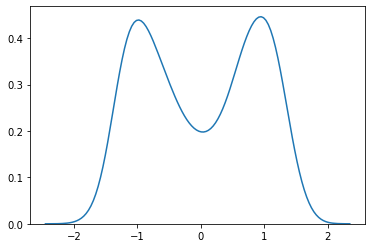

In [6]:
import seaborn as sns
plt = sns.kdeplot(res[0,:])
fig = plt.get_figure()
fig.show()

In [7]:
%timeit cpp.sghmc(eps, C, Mmatrix, theta_initial, Cov_hat, epoch_nums, n_data, size)

316 ms ± 6.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
